In [1]:
!pip install pandas numpy matplotlib seaborn wordcloud scikit-learn torch transformers


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer


In [3]:

# load dataset
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'text'])
    test_df = pd.read_csv(test_path, header=None, names=['label', 'title', 'text'])
    return train_df, test_df

# data Overview
def dataset_overview(df, name):
    print(f"Dataset: {name}")
    print("-" * 50)
    print(df.info())
    print(df.describe(include='all'))
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())

# Class Distribution
def plot_class_distribution(df, title):
    plt.figure(figsize=(10,5))
    sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')
    plt.title(f'Class Distribution - {title}')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()

# text Length Analysis
def text_length_analysis(df, column):
    df['text_length'] = df[column].apply(lambda x: len(str(x).split()))
    plt.figure(figsize=(10,5))
    sns.histplot(df['text_length'], bins=30, kde=True, color='blue')
    plt.title(f'Distribution of Text Length in {column}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()
    print(df['text_length'].describe())

# word Cloud
def generate_wordcloud(df, column):
    text = ' '.join(df[column].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column}')
    plt.show()

# most Common Words
def most_common_words(df, column, n=20):
    text = ' '.join(df[column].astype(str).str.lower())
    words = re.findall(r'\b[a-z]{3,}\b', text)
    common_words = Counter(words).most_common(n)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(f'Top {n} Most Common Words in {column}')
    plt.xlabel('Count')
    plt.ylabel('Word')
    plt.show()

/tmp/ipykernel_342943/727687099.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'text'])


Dataset: Train Set
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560001 entries, 0 to 560000
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   560001 non-null  object
 1   title   560001 non-null  object
 2   text    560001 non-null  object
dtypes: object(3)
memory usage: 12.8+ MB
None
         label   title                                               text
count   560001  560001                                             560001
unique      16  560001                                             559880
top          0   title   Tom Clancy's Net Force Explorers or Net Force...
freq     40000       1                                                 15

Missing values:
label    0
title    0
text     0
dtype: int64

Duplicate rows: 0
Dataset: Test Set
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70001 entries, 0 t

/tmp/ipykernel_342943/727687099.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')


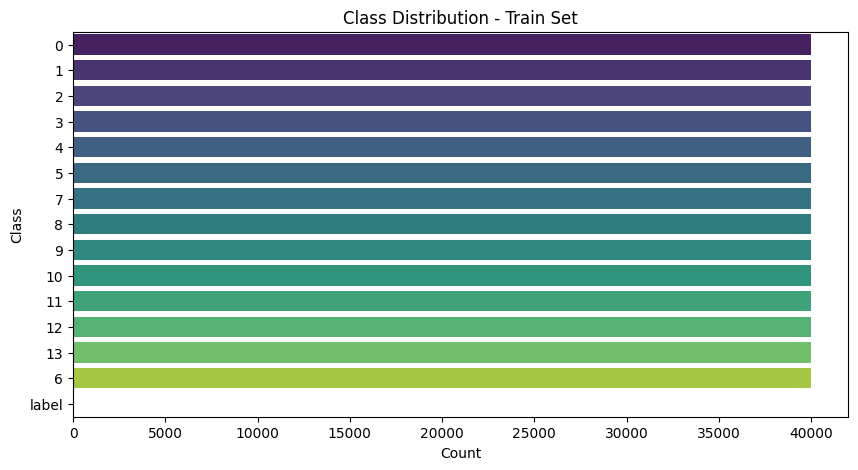

/tmp/ipykernel_342943/727687099.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['label'], order=df['label'].value_counts().index, palette='viridis')


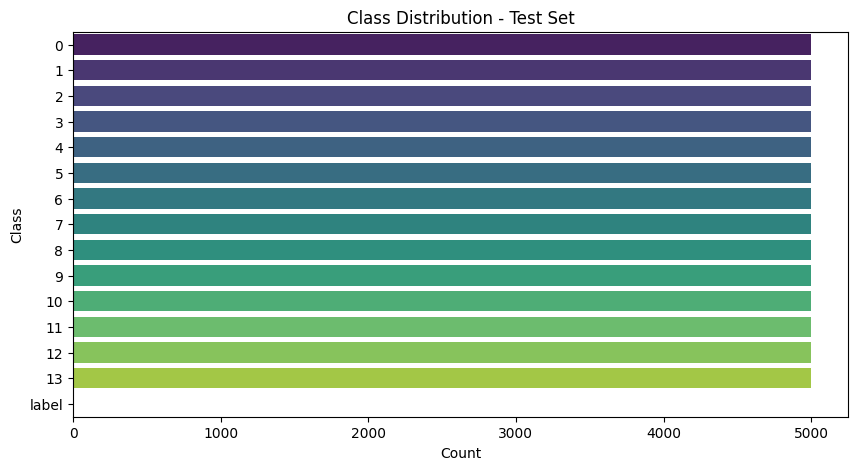

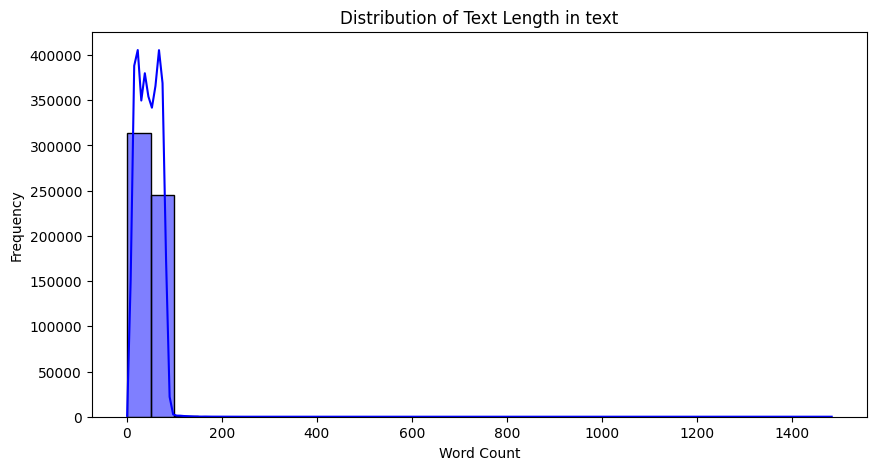

count    560001.000000
mean         46.133153
std          22.469242
min           1.000000
25%          27.000000
50%          46.000000
75%          65.000000
max        1484.000000
Name: text_length, dtype: float64


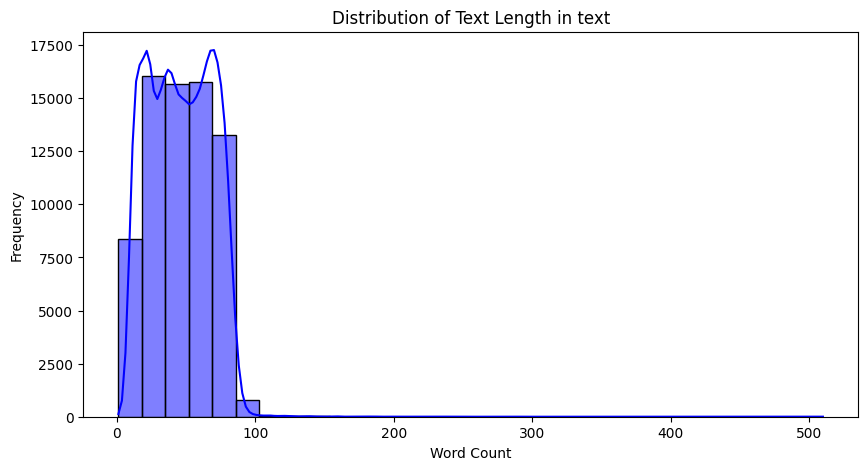

count    70001.000000
mean        46.140812
std         22.364355
min          1.000000
25%         27.000000
50%         46.000000
75%         65.000000
max        510.000000
Name: text_length, dtype: float64


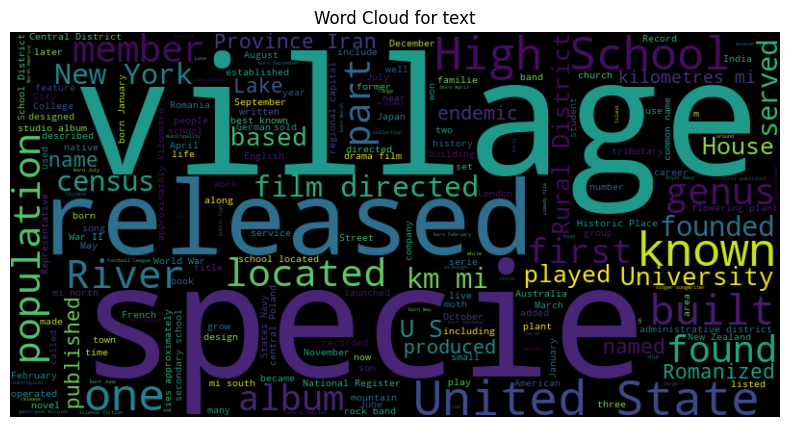

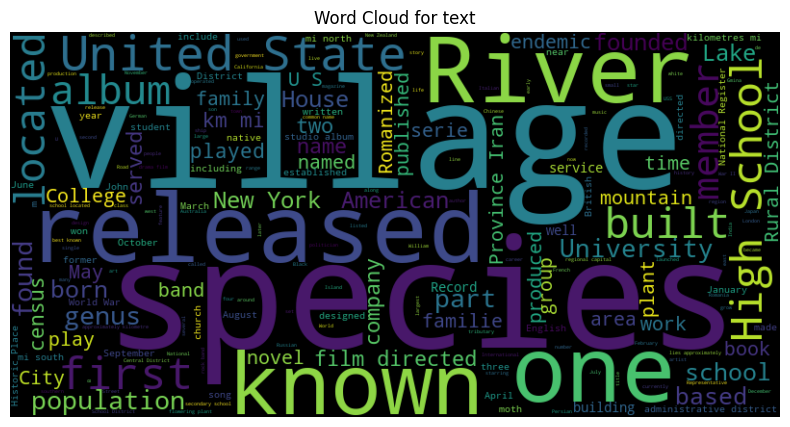

/tmp/ipykernel_342943/727687099.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


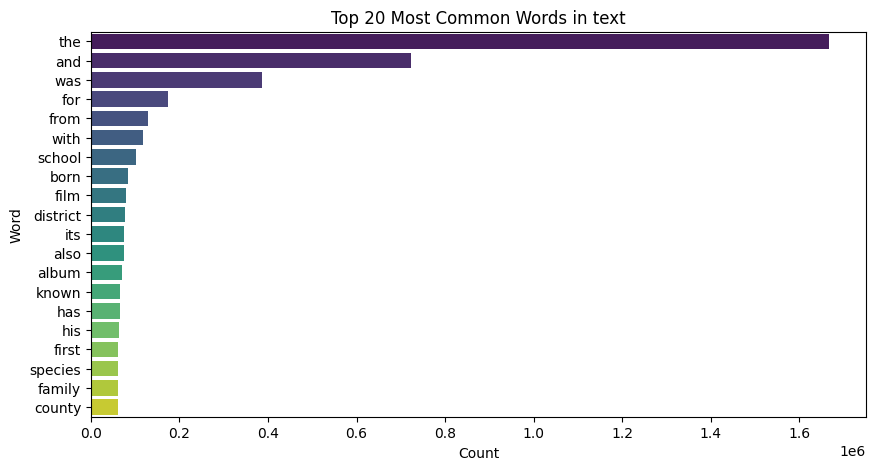

/tmp/ipykernel_342943/727687099.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


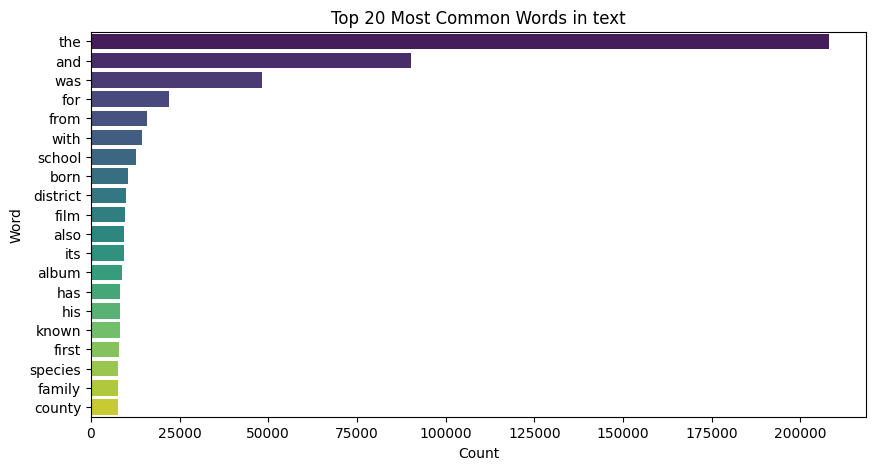

In [4]:
# load and analyzing dataset
train_path = '/home/momo/Documents/Datasets/Text/train.csv'
test_path = '/home/momo/Documents/Datasets/Text/test.csv'

train_df, test_df = load_data(train_path, test_path)

dataset_overview(train_df, 'Train Set')
dataset_overview(test_df, 'Test Set')

plot_class_distribution(train_df, 'Train Set')
plot_class_distribution(test_df, 'Test Set')

text_length_analysis(train_df, 'text')
text_length_analysis(test_df, 'text')

generate_wordcloud(train_df, 'text')
generate_wordcloud(test_df, 'text')

most_common_words(train_df, 'text')
most_common_words(test_df, 'text')


In [5]:


# implement EPASS
def epass_model(train_df, test_df):
    print("Running EPASS...")
    
    # simple Ensemble Projection implementation
    class EPASSModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(EPASSModel, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x
    
    # simulated training process
    input_dim = 300  
    hidden_dim = 128
    output_dim = len(train_df['label'].unique())
    model = EPASSModel(input_dim, hidden_dim, output_dim)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(5):  # simulating 5 epochs
        optimizer.zero_grad()
        dummy_inputs = torch.randn(32, input_dim)  # simulated input batch
        dummy_labels = torch.randint(0, output_dim, (32,))  # simulated labels
        outputs = model(dummy_inputs)
        loss = criterion(outputs, dummy_labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")
    
    return "EPASS Training Completed"


# implement JointMatch
def jointmatch_model(train_df, test_df):
    print("Running JointMatch...")
    
    class JointMatchModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(JointMatchModel, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        def forward(self, x):
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            return x
    
    input_dim = 300
    hidden_dim = 128
    output_dim = len(train_df['label'].unique())
    model = JointMatchModel(input_dim, hidden_dim, output_dim)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(5):
        optimizer.zero_grad()
        dummy_inputs = torch.randn(32, input_dim)
        dummy_labels = torch.randint(0, output_dim, (32,))
        outputs = model(dummy_inputs)
        loss = criterion(outputs, dummy_labels)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")
    
    return "JointMatch Training Completed"

# compare models
def compare_models(epass_results, jointmatch_results):
    print("Comparing EPASS and JointMatch")
    print("EPASS:", epass_results)
    print("JointMatch:", jointmatch_results)

# load and analyze dataset
train_path = '/home/momo/Documents/Datasets/Text/train.csv'
test_path = '/home/momo/Documents/Datasets/Text/test.csv'

train_df, test_df = load_data(train_path, test_path)

dataset_overview(train_df, 'Train Set')
dataset_overview(test_df, 'Test Set')

# run EPASS and JointMatch
epass_results = epass_model(train_df, test_df)
jointmatch_results = jointmatch_model(train_df, test_df)

# compare results
compare_models(epass_results, jointmatch_results)


/tmp/ipykernel_342943/727687099.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, header=None, names=['label', 'title', 'text'])


Dataset: Train Set
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560001 entries, 0 to 560000
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   560001 non-null  object
 1   title   560001 non-null  object
 2   text    560001 non-null  object
dtypes: object(3)
memory usage: 12.8+ MB
None
         label   title                                               text
count   560001  560001                                             560001
unique      16  560001                                             559880
top          0   title   Tom Clancy's Net Force Explorers or Net Force...
freq     40000       1                                                 15

Missing values:
label    0
title    0
text     0
dtype: int64

Duplicate rows: 0
Dataset: Test Set
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70001 entries, 0 t